# Advanced Example: orientation and aspect ratio

In this example, we show how to use inertia matrix of a given labeled object to find its orientation. 

![](./balls.jpg)

[balls.jpg](./balls.jpg)





In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import ndimage
import pandas as pd
import os
%matplotlib nbagg

In [80]:
path = "balls.jpg"
files = os.listdir("./")
if path in files:
    print("Ok, the file is in {0}".format(files))
else:
    print("The file is not in {0} , retry !".format(files))

Ok, the file is in ['Image_Processing_Tutorial_3.ipynb', 'Orientation.ipynb', '.ipynb_checkpoints', 'Image_Processing_Tutorial_4.ipynb', 'bugs.jpg', 'Image_Processing_Tutorial_2.ipynb', 'balls.jpg', 'Image_Processing_Tutorial_1.ipynb']


In order to explain the concepts of inertia and aspect ratio, we use this magnificient hand drawing:

<IPython.core.display.Javascript object>


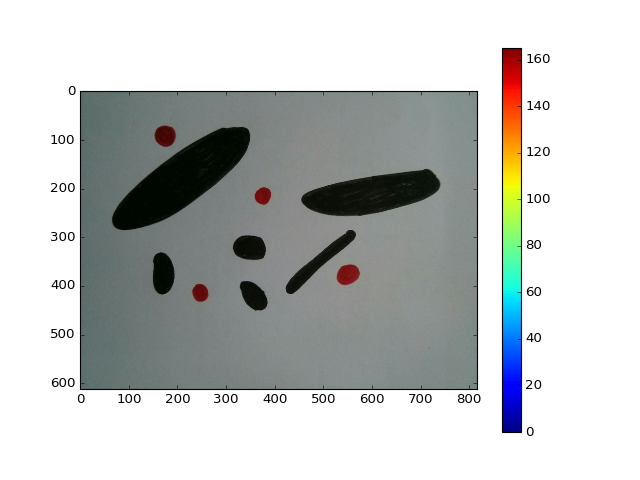

In [81]:
im = Image.open(path)
Nc, Nl = im.size
im = im.resize((Nc // 4 ,Nl // 4),Image.ANTIALIAS)
fig, ax = plt.subplots()
#ax.axis("off")
plt.imshow(im)
plt.colorbar()
plt.show()

In [82]:
R, G, B = im.split()
R = np.array(R)
G = np.array(G)
B = np.array(B)

<IPython.core.display.Javascript object>


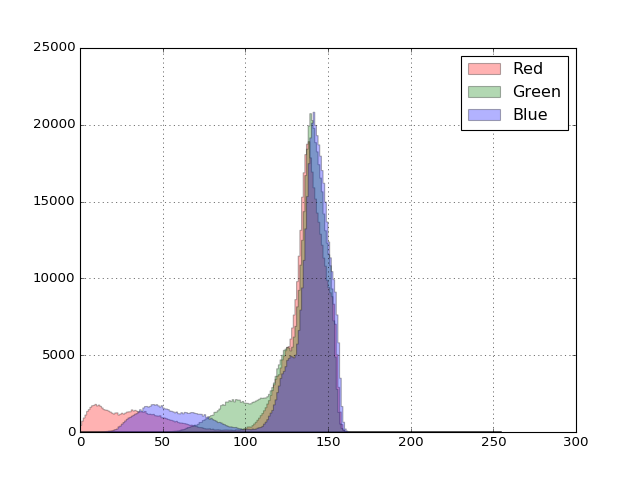

In [39]:
plt.figure()
plt.hist(R.flatten(), bins = np.arange(256), histtype = "stepfilled", color = "r", alpha = .3, label = "Red")
plt.hist(G.flatten(), bins = np.arange(256), histtype = "stepfilled", color = "g", alpha = .3, label = "Green")
plt.hist(B.flatten(), bins = np.arange(256), histtype = "stepfilled", color = "b", alpha = .3, label = "Blue")
plt.grid()
plt.legend()
plt.show()

Thresholding level is obvious:

<IPython.core.display.Javascript object>


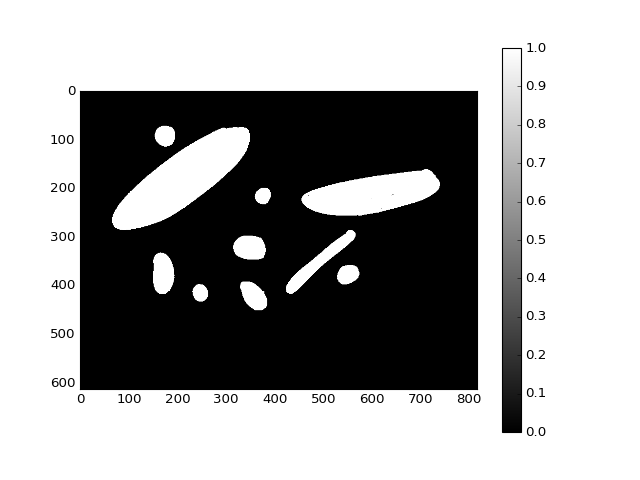

In [83]:
Bt = np.where(B < 50, 1, 0)
plt.figure()
plt.imshow(Bt, cmap = cm.gray)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


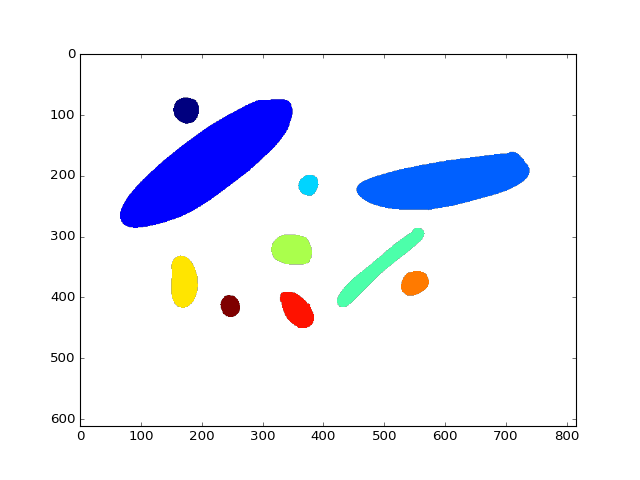

10

In [84]:
Btc = ndimage.binary_closing(Bt, structure = np.ones((10, 10)))


Bl, number  = ndimage.measurements.label(Btc)
plt.figure()
plt.imshow(np.where(Bl !=0, Bl, np.nan), cmap = cm.jet)
plt.show()
number

In [85]:
obj = ndimage.measurements.find_objects(Bl)
len(obj)

10

## Inertia matrix of an object

The object represented bellow is stretched in a direction. Let's see how we can use its inertia matrix to determine in which direction and how much it is stretched.

<IPython.core.display.Javascript object>


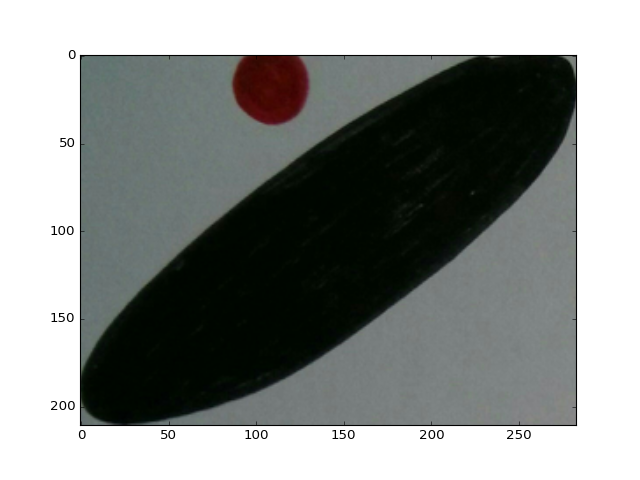

In [86]:
plt.figure()
plt.imshow(np.array(im)[obj[1]])
plt.show()

The inertia matrix of a 2D object can be defined as follows:

$$
I = 
\begin{bmatrix} 
I_{xx} & -I_{xy} \\
-I_{xy} & I_{yy} \\
\end{bmatrix}
$$

This matrix is symmetric and, as a consequence, it can be diagonalized in a new frame rotated by an angle $\theta$ in the plane. This frame is composed of the two normalized eigenvectors $(\vec e_1, \vec e_2)$ of the matrix. In this frame, the matrix has two eigenvalues $(I_1, I_2)$ ordered so that $I_1 \geq I_2$. Then: 
* $\theta = (\vec x, \vec e_1)$ and,
* The aspect ratio $a = \sqrt{I_1 / I_2}$.

The angle $\theta$ gives the direction of the elongation of the object and $a$ shows how much it is elongated. For example,  if $a == 1$, the object is not elongated whereas if $a=10$ it is 10 times longer in direction 1 than in direction 2 in an inertial point of view.

In [95]:
data = pd.DataFrame(columns = ["area", "xg", "yg", "Ixx", "Iyy", "Ixy", "I1", "I2", "theta"])
for i in range(len(obj)):
    x, y = np.where(Bl == i+1)
    xg, yg = x.mean(), y.mean()
    x = x - xg
    y = y - yg
    A = len(x)
    Ixx = (y**2).sum()
    Iyy = (x**2).sum()
    Ixy = (x*y).sum()
    I = np.array([[Ixx, -Ixy], [-Ixy, Iyy]])
    eigvals, eigvecs = np.linalg.eig(I)
    eigvals = abs(eigvals)
    loc = np.argsort(eigvals)[::-1]
    d = eigvecs[loc[0]]
    d *= np.sign(d[0])
    theta =  np.degrees(np.arccos(d[1]))
    eigvals = eigvals[loc]
    data.loc[i] = [A, xg, yg, Ixx, Iyy, Ixy, eigvals[0], eigvals[1], theta]
data.sort_values("area", inplace = True, ascending = False)
data["aspect_ratio"] = (data.I1 / data.I2)**.5

data[["area","theta", "aspect_ratio"]]

area       theta  aspect_ratio
1  27036.0  125.441405      3.367242
2  17453.0   99.074781      3.837729
4   4204.0  131.093224      7.616207
6   3039.0    2.379166      1.955832
5   2736.0   82.039928      1.359502
8   2291.0   39.208508      1.710753
0   1438.0   25.883299      1.024153
7   1433.0  117.968405      1.265832
9    905.0   15.912720      1.151798
3    872.0  149.487814      1.112203

<IPython.core.display.Javascript object>


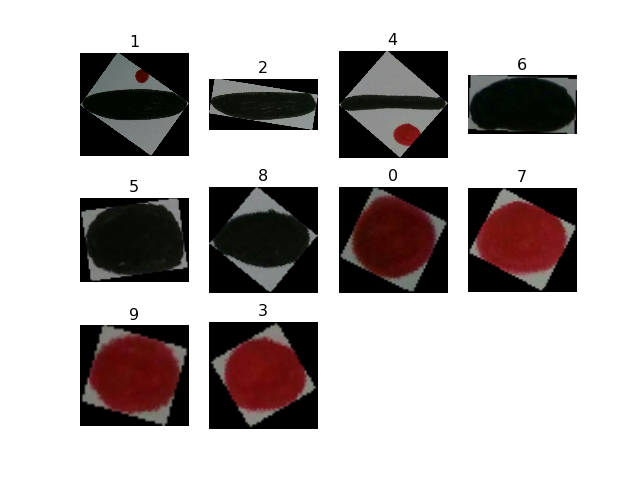

In [96]:
fig = plt.figure()
counter = 1
for i in data.index.values:
    ax = fig.add_subplot(3,4, counter)
    z = Image.fromarray(np.array(im)[obj[i]])
    z = z.rotate(-data.loc[i, "theta"]+90, expand = True)
    z = np.array(z)
    plt.imshow(z)
    plt.title(str(i))
    ax.axis("off")
    counter += 1
    #plt.grid()
plt.show()    